In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
seed = 17102016

rng = np.random.RandomState(seed)

In [22]:
def polynomial_function(inputs, coefficients):
    inputs = np.array([inputs ** i for i in range(coefficients.shape[0])])
    outputs = np.dot(inputs.T, coefficients)
    return outputs

In [23]:
test_coefficients = np.array([-1., 3., 4.])
test_inputs = np.array([0., 0.5, 1., 2.])
test_outputs = np.array([-1., 1.5, 6., 21.])
assert polynomial_function(test_inputs, test_coefficients).shape == (4,),(
    'Function gives wrong shape output.'
)
assert np.allclose(polynomial_function(test_inputs, test_coefficients),test_outputs),(
    'Function gives incorrect output values.'
)
print("Function is correct!")

Function is correct!


In [24]:
coefficients = np.array([0, -1, 8., -17., 10.])
input_dim, output_dim = 1, 1
noise_std = 0.01
num_data = 80
inputs = rng.uniform(size=(num_data, input_dim))
epsilons = rng.normal(size=num_data)
targets = (polynomial_function(inputs[:, 0], coefficients) + 
           epsilons * noise_std)[:, None]

In [26]:
from mlp.data_providers import DataProvider
num_train = num_data // 2
batch_size= num_train
inputs_train, targets_train = inputs[:num_train], targets[:num_train]
inputs_valid, targets_valid = inputs[num_train:], targets[num_train:]
train_data = DataProvider(inputs_train, targets_train, batch_size=batch_size, rng=rng)
valid_data = DataProvider(inputs_valid, targets_valid, batch_size=batch_size, rng=rng)

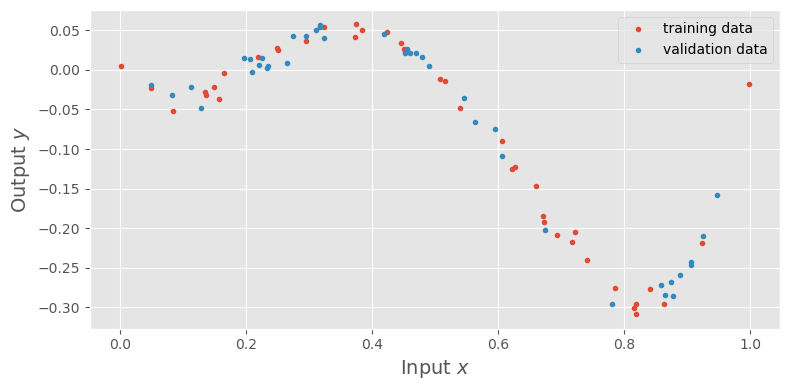

In [28]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax.plot(inputs_train[:, 0], targets_train[:, 0], '.', label='training data')
ax.plot(inputs_valid[:, 0], targets_valid[:, 0], '.', label='validation data')
ax.set_xlabel('Input $x$', fontsize=14)
ax.set_ylabel('Output $y$', fontsize=14)
ax.legend(loc='best')
fig.tight_layout()
plt.show()

# Model

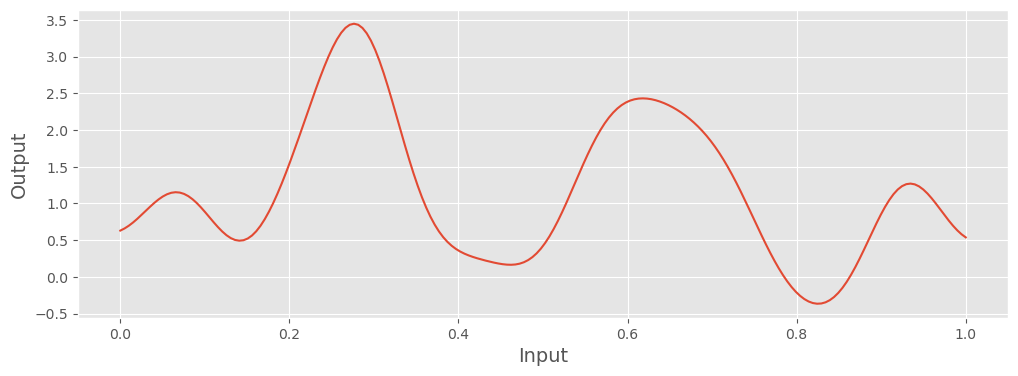

In [33]:
num_weights = 15
weights_scale = 1
bias_scale = 1

def basis_function(x, centre, scale):
    return np.exp(-(x - centre)**2 / scale**2)

weights = rng.normal(size=num_weights) * weights_scale
bias = rng.normal() * bias_scale

centres = np. linspace(0, 1, weights.shape[0])
scale = 1. /weights.shape[0]

xs = np.linspace(0, 1, 200)
ys = np.zeros(xs.shape[0])

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)
for weight, centre in zip(weights, centres):
    ys += weight * basis_function(xs, centre, scale)
ys += bias
ax.plot(xs, ys)
ax.set_xlabel('Input', fontsize=14)
ax.set_ylabel('Output', fontsize=14)
plt.show()

In [34]:
from mlp.models import MultipleLayerModel
from mlp.layers import AffineLayer, RadialBasisFunctionLayer
from mlp.errors import SumOfSquaredDiffsError
from mlp.initialisers import ConstantInit, UniformInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.optimisers import Optimiser

error = SumOfSquaredDiffsError()
learning_rule = GradientDescentLearningRule(0.1)
weights_init = UniformInit(-0.1, 0.1)
biases_init = ConstantInit(0.)
num_epoch = 2000

In [35]:
num_weight_list = [2, 5, 10, 25, 50, 100]
models = []
train_errors = []
valid_errors = []
for num_weight in num_weight_list:
    model = MultipleLayerModel([
        RadialBasisFunctionLayer(num_weight),
        AffineLayer(input_dim * num_weight, output_dim,
                    weights_init, biases_init)
    ])
    optimiser = Optimiser(model, error, learning_rule,
                          train_data, valid_data)
    print('-' * 80)
    print('Training model with {0} weights'.format(num_weight))
    print('-' * 80)
    _ = optimiser.train(num_epoch, -1)
    outputs_train = model.fprop(inputs_train)[-1]
    outputs_valid = model.fprop(inputs_valid)[-1]
    models.append(model)
    train_errors.append(error(outputs_train, targets_train))
    valid_errors.append(error(outputs_valid, targets_valid))
    print(' Final training set error:{0:.1e}'.format(train_errors[-1]))
    print(' Final validation set error:{0:.1e}'.format(valid_errors[-1]))

--------------------------------------------------------------------------------
Training model with 2 weights
--------------------------------------------------------------------------------
 Final training set error:2.0e-03
 Final validation set error:1.1e-03
--------------------------------------------------------------------------------
Training model with 5 weights
--------------------------------------------------------------------------------
 Final training set error:4.5e-04
 Final validation set error:3.0e-04
--------------------------------------------------------------------------------
Training model with 10 weights
--------------------------------------------------------------------------------
 Final training set error:5.1e-05
 Final validation set error:8.3e-05
--------------------------------------------------------------------------------
Training model with 25 weights
--------------------------------------------------------------------------------
 Final training set 

### Plot the bar chart

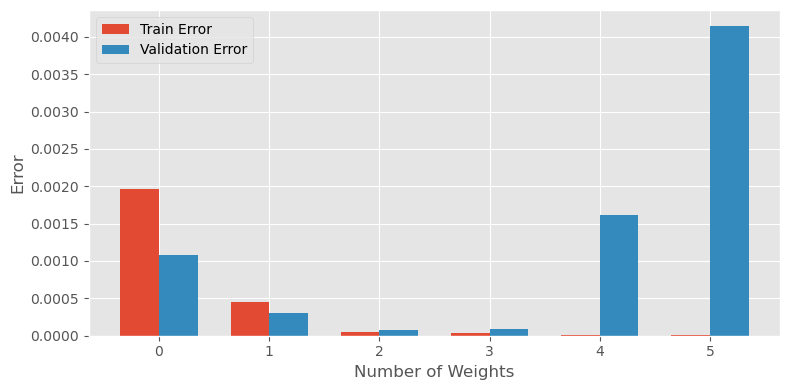

In [43]:
width = 0.35
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
idx = np.arange(len(num_weight_list))
plt.bar(idx-width/2, train_errors, width=width, label='Train Error')
plt.bar(idx+width/2, valid_errors, width=width, label='Validation Error')
plt.xlabel('Number of Weights')
plt.ylabel('Error')
plt.legend()
plt.tight_layout()
plt.show()

Some questions to think about from the plots:

  * Do the models with more free parameters fit the training data better or worse?  
    Models with more free parameters (i.e., more weights) fit the training data **better**. As seen from the results, the training error decreases as the number of weights increases. However, this does not necessarily mean the model generalizes well.

  * What does the validation set error value tell us about the models?  
    The validation error helps indicate how well the model **generalizes** to unseen data. A low validation error suggests that the model performs well on data it hasn't seen before. When the validation error starts increasing while the training error decreases (as seen with 50 and 100 weights), it indicates overfitting, meaning the model is too complex and is capturing noise in the training data rather than the underlying pattern.

  * Of the models fitted here which would you say seems like it is most likely to generalise well to unseen data?   
    The model with **10 weights** appears to generalize best. It has a low validation error (8.3e-05) and doesn't show signs of overfitting, unlike models with more weights (50, 100), where the validation error starts increasing.

  * Do any of the models seem to be overfitting?  
    Yes, the models with **50 and 100 weights** show clear signs of overfitting. Their training errors are very low, but the validation errors are significantly higher, indicating that these models are fitting the training data too closely, including noise, which harms their performance on unseen data.

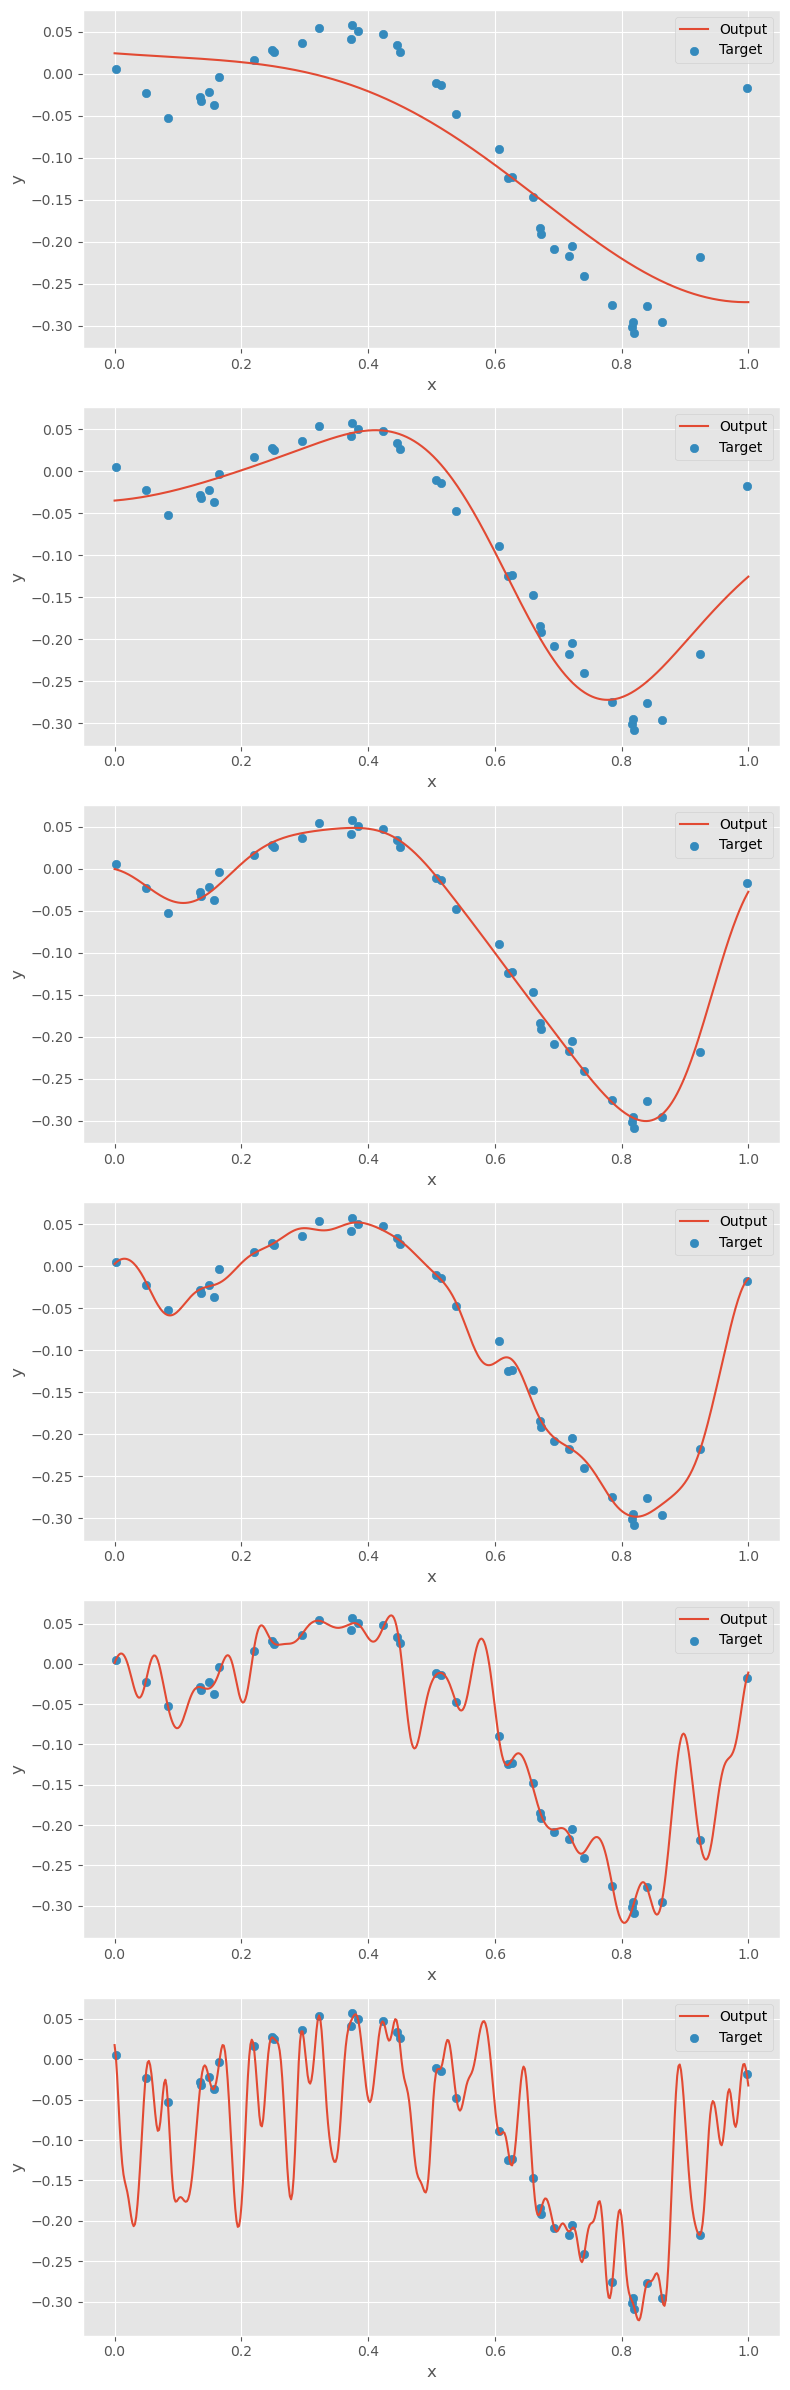

In [50]:
ggplot_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(8, len(models) * 4))
x_range = np.linspace(0, 1, 500)[:, None]
targets = polynomial_function(x_range[:, 0], coefficients)
for i, model in enumerate(models):
    outputs = model.fprop(x_range)[-1]
    ax = axes[i]
    ax.plot(x_range, outputs, color=ggplot_colors[0], label='Output', linestyle='-')
    ax.scatter(inputs_train[:, 0], targets_train, color=ggplot_colors[1], label='Target', linestyle='-')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()

plt.tight_layout()
plt.show()
    

# Pytorch
### Early stoppping

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

torch.manual_seed(seed)

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 128
learning_rate = 0.001
num_epochs = 50
stats_interval = 1

In [53]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, download=True, transform=transform)

valid_size=0.2
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [54]:
class MultipleLayerModel(nn.Module):
    """Multiple layer model."""
    def __init__(self, input_dim, output_dim, hidden_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
input_dim = 1*28*28
output_dim = 10
hidden_dim = 100

model = MultipleLayerModel(input_dim, output_dim, hidden_dim).to(device)

loss = nn.CrossEntropyLoss() # Cross-entropy loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam optimiser

In [55]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience =patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.early_stop = False
    
    def __call__(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [56]:
early_stopping = EarlyStopping(patience=5, min_delta=0.01)

# Keep track of the loss values over training
train_loss = [] 
valid_loss = []

# Train model
for i in range(num_epochs+1):
    # Training
    model.train()
    batch_loss = []
    for batch_idx, (x, t) in enumerate(train_loader):
        x = x.to(device)
        t = t.to(device)
        
        # Forward pass
        y = model(x)
        E_value = loss(y, t)
        
        # Backward pass
        optimizer.zero_grad()
        E_value.backward()
        optimizer.step()
        
        # Logging
        batch_loss.append(E_value.item())
    
    train_loss.append(np.mean(batch_loss))

    # Validation
    model.eval()
    batch_loss = []
    for batch_idx, (x, t) in enumerate(valid_loader):
        x = x.to(device)
        t = t.to(device)
        
        # Forward pass
        y = model(x)
        E_value = loss(y, t)
        
        # Logging
        batch_loss.append(E_value.item())
    
    valid_loss.append(np.mean(batch_loss))

    if i % stats_interval == 0:
            print('Epoch: {} \tError(train): {:.6f} \tError(valid): {:.6f} '.format(
                i, train_loss[-1], valid_loss[-1]))
    early_stopping(valid_loss[-1])

    if early_stopping.early_stop:
         print("Early Stopping")
         break

Epoch: 0 	Error(train): 0.355602 	Error(valid): 0.179833 
Epoch: 1 	Error(train): 0.145722 	Error(valid): 0.131999 
Epoch: 2 	Error(train): 0.104012 	Error(valid): 0.114437 
Epoch: 3 	Error(train): 0.078600 	Error(valid): 0.099346 
Epoch: 4 	Error(train): 0.061731 	Error(valid): 0.096692 
Epoch: 5 	Error(train): 0.047770 	Error(valid): 0.101177 
Epoch: 6 	Error(train): 0.038963 	Error(valid): 0.091598 
Epoch: 7 	Error(train): 0.031250 	Error(valid): 0.094620 
Epoch: 8 	Error(train): 0.028064 	Error(valid): 0.110890 
Epoch: 9 	Error(train): 0.023656 	Error(valid): 0.102022 
Epoch: 10 	Error(train): 0.021725 	Error(valid): 0.116701 
Epoch: 11 	Error(train): 0.016627 	Error(valid): 0.102217 
Epoch: 12 	Error(train): 0.014034 	Error(valid): 0.103265 
Early Stopping


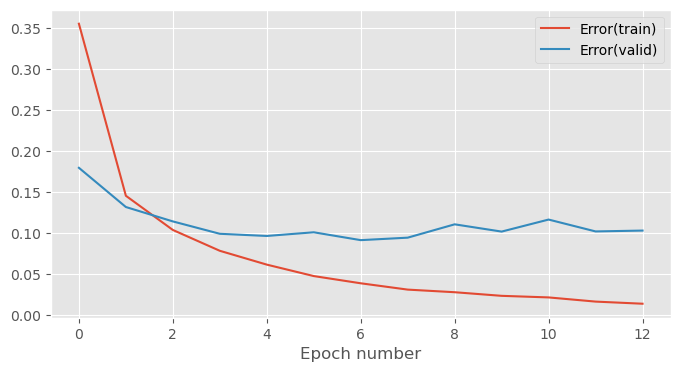

In [57]:
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
ax_1.plot(train_loss, label='Error(train)')
ax_1.plot(valid_loss, label='Error(valid)')
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')
plt.show()